# Fitting

In [2]:
import sys
sys.path.insert(0, '../../../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle as pkl
import tensorflow as tf

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import ProbabilityMSE, ProbabilityRValue, channel_fidelity_loss
from optimization import ModelSPAM, ModelQuantumMap, Logger, model_saver
from quantum_channel import DilutedChannel, ChoiMapStatic
from quantum_tools import apply_unitary, measurement, resample, state_fidelity
from experimental import counts_to_probs, generate_pauliInput_circuits, generate_pauli_circuits, marginalize_counts
from spam import SPAM, InitialState, POVMwQR as POVM, IdealPOVM, IdealInit, povm_fidelity, CorruptionMatrix
from synthetic_data import generate_spam_data, generate_map_data
from utils import saver, loader, train_val_split
from quantum_circuits import pqc_basic
from spectrum import channel_spectrum, complex_spacing_ratio, Spectrum, coat_spectrum, spectrum_to_angular, spectrum_to_radial
from analysis import hist_ensamble
from qiskit.circuit.library import iSwapGate


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
def model_to_csr(model_list):
    csr_list = []
    for model in model_list:
        channel = model.channel
        spectrum = channel_spectrum(channel)

        csr = complex_spacing_ratio(spectrum)
        csr_list.append(csr)
        
    return csr_list
    

In [4]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)

# Increase font size
plt.rcParams.update({'font.size': 14})

In [5]:
model_integrable_list = pkl.load(open(f'../models/integrable_model_4_L=5.model', 'rb'))

csr_integrable_list = model_to_csr(model_integrable_list)

radial_integrable_L5_list = spectrum_to_radial(csr_integrable_list)
angular_integrable_L5_list = spectrum_to_angular(csr_integrable_list)

model_integrable_list = pkl.load(open(f'../models/integrable_model_4_L=20_reorder.model', 'rb'))
csr_integrable_list = model_to_csr(model_integrable_list)
radial_integrable_L20_list = spectrum_to_radial(csr_integrable_list)
angular_integrable_L20_list = spectrum_to_angular(csr_integrable_list)

model_integrable_list = pkl.load(open(f'../models/integrable_model_4_L=50_reorder.model', 'rb'))
csr_integrable_list = model_to_csr(model_integrable_list)
radial_integrable_L50_list = spectrum_to_radial(csr_integrable_list)
angular_integrable_L50_list = spectrum_to_angular(csr_integrable_list)

## Comparison with Theory

### Radial

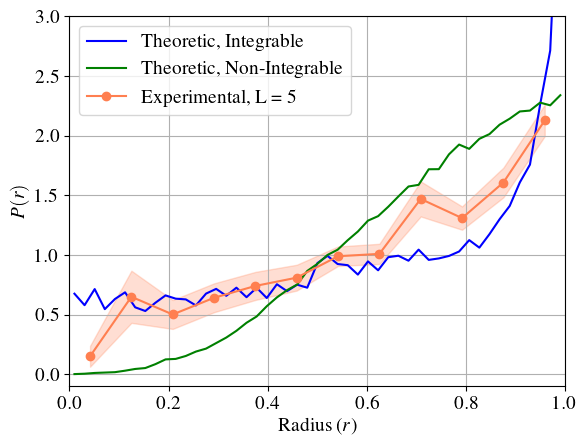

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)

center_bins, hist, hist_err = loader("../data/radial_integrable.data")
ax.plot(center_bins, hist, 'b-', 
        label='Theoretic, Integrable',
        )

center_bins, hist, hist_err = loader("../data/radial_nonintegrable.data")
ax.plot(center_bins, hist, 'g-', 
         label='Theoretic, Non-Integrable',
         )

center_bins, hist, hist_err = hist_ensamble(radial_integrable_L5_list, bins=np.linspace(0, 1, 13))
ax.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.25, color="coral" )
ax.plot(center_bins, hist, 'o-', label='Experimental, L = 5', color="coral")




plt.xlim(0, 1)
plt.ylim(-0.1, 3.)
plt.xlabel(r'Radius ($r$)')
plt.ylabel(r'$P(r)$')
ax.grid(True)
#ax.set_yticklabels([])
plt.legend()
plt.savefig("../figures/transition_radial_L=5.svg", bbox_inches='tight')

plt.show()

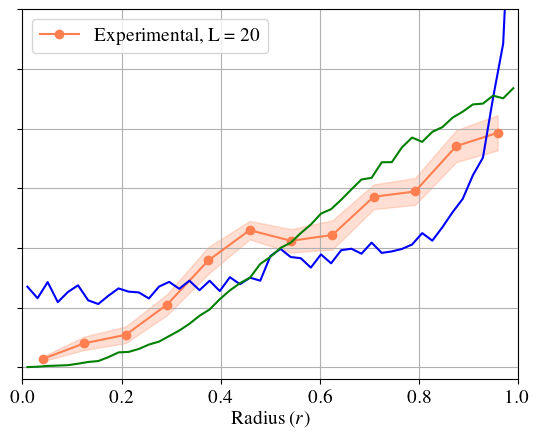

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

center_bins, hist, hist_err = hist_ensamble(radial_integrable_L20_list, bins=np.linspace(0, 1, 13))
ax.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.25, color="coral" )
ax.plot(center_bins, hist, 'o-', label='Experimental, L = 20', color="coral")

center_bins, hist, hist_err = loader("../data/radial_integrable.data")
ax.plot(center_bins, hist, 'b-', 
 #       label='Theoretic, Integrable',
        )

center_bins, hist, hist_err = loader("../data/radial_nonintegrable.data")
ax.plot(center_bins, hist, 'g-', 
#         label='Theoretic, Non-Integrable',
         )



plt.xlim(0, 1)
plt.ylim(-0.1, 3.)
plt.xlabel(r'Radius ($r$)')
#plt.ylabel(r'$P(r)$')
ax.grid(True)
ax.set_yticklabels([])
plt.legend()
plt.savefig("../figures/transition_radial_L=20.svg", bbox_inches='tight')

plt.show()

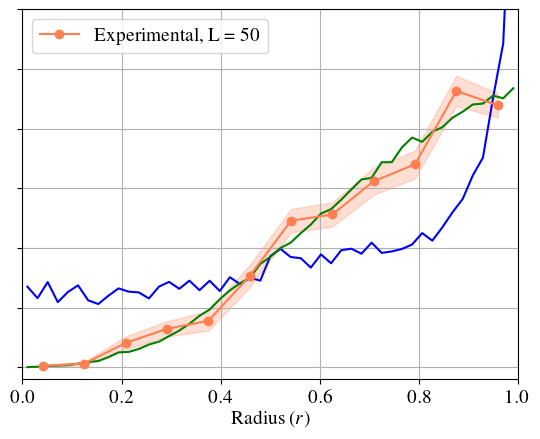

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)


center_bins, hist, hist_err = loader("../data/radial_integrable.data")
ax.plot(center_bins, hist, 'b-', 
 #       label='Theoretic, Integrable',
        )

center_bins, hist, hist_err = loader("../data/radial_nonintegrable.data")
ax.plot(center_bins, hist, 'g-', 
#         label='Theoretic, Non-Integrable',
         )

center_bins, hist, hist_err = hist_ensamble(radial_integrable_L50_list, bins=np.linspace(0, 1, 13))
ax.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.25, color="coral" )
ax.plot(center_bins, hist, 'o-', label='Experimental, L = 50', color="coral")



plt.xlim(0, 1)
plt.ylim(-0.1, 3.)
plt.xlabel(r'Radius ($r$)')
#plt.ylabel(r'$P(r)$')
ax.grid(True)
ax.set_yticklabels([])
plt.legend()
plt.savefig("../figures/transition_radial_L=50.svg", bbox_inches='tight')

plt.show()

### Angular

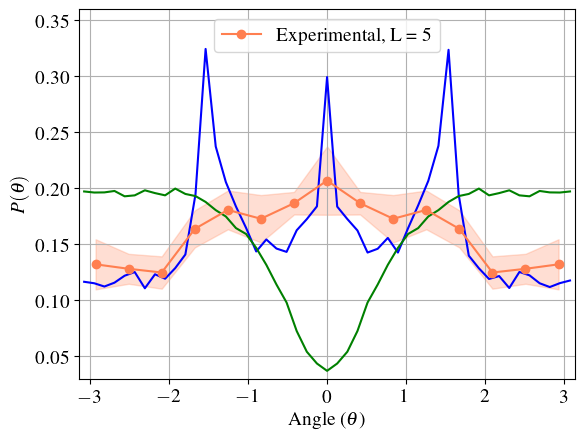

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

center_bins, hist, hist_err = loader("../data/angular_integrable.data")
ax.plot(center_bins, hist, 'b-', 
 #       label='Theoretic, Integrable',
        )

center_bins, hist, hist_err = loader("../data/angular_nonintegrable.data")
ax.plot(center_bins, hist, 'g-', 
 #        label='Theoretic, Non-Integrable',
         )

center_bins, hist, hist_err = hist_ensamble(angular_integrable_L5_list, bins=np.linspace(-np.pi, np.pi, 16))
ax.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.25, color="coral" )
ax.plot(center_bins, hist, 'o-', label='Experimental, L = 5', color="coral")


plt.xlim(-np.pi, np.pi)
plt.ylim(0.03, 0.36)
plt.xlabel(r'Angle ($\theta$)')
plt.ylabel(r'$P(\theta)$')
ax.grid(True)
plt.legend()
plt.savefig("../figures/transition_angular_L=5.svg", bbox_inches='tight')

plt.show()

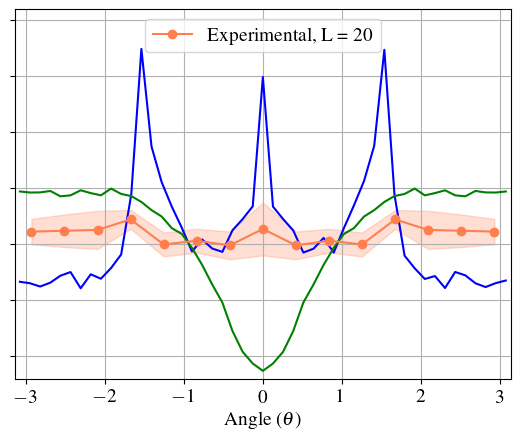

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

center_bins, hist, hist_err = loader("../data/angular_integrable.data")
ax.plot(center_bins, hist, 'b-', 
 #       label='Theoretic, Integrable',
        )

center_bins, hist, hist_err = loader("../data/angular_nonintegrable.data")
ax.plot(center_bins, hist, 'g-', 
 #        label='Theoretic, Non-Integrable',
         )

center_bins, hist, hist_err = hist_ensamble(angular_integrable_L20_list, bins=np.linspace(-np.pi, np.pi, 16))
ax.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.25, color="coral" )
ax.plot(center_bins, hist, 'o-', label='Experimental, L = 20', color="coral")


plt.xlim(-np.pi, np.pi)
plt.ylim(0.03, 0.36)
plt.xlabel(r'Angle ($\theta$)')
#plt.ylabel(r'$P(\theta)$')
ax.grid(True)
ax.set_yticklabels([])
plt.legend()
plt.savefig("../figures/transition_angular_L=20.svg", bbox_inches='tight')

plt.show()

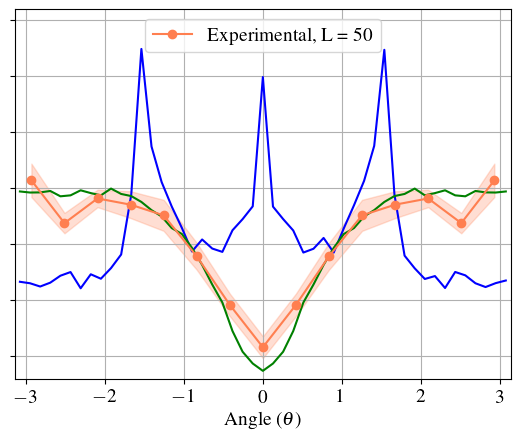

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

center_bins, hist, hist_err = loader("../data/angular_integrable.data")
ax.plot(center_bins, hist, 'b-', 
 #       label='Theoretic, Integrable',
        )

center_bins, hist, hist_err = loader("../data/angular_nonintegrable.data")
ax.plot(center_bins, hist, 'g-', 
 #        label='Theoretic, Non-Integrable',
         )

center_bins, hist, hist_err = hist_ensamble(angular_integrable_L50_list, bins=np.linspace(-np.pi, np.pi, 16))
ax.fill_between(center_bins, (hist-hist_err), (hist+hist_err), alpha=0.25, color="coral" )
ax.plot(center_bins, hist, 'o-', label='Experimental, L = 50', color="coral")


plt.xlim(-np.pi, np.pi)
plt.ylim(0.03, 0.36)
plt.xlabel(r'Angle ($\theta$)')
#plt.ylabel(r'$P(\theta)$')
ax.grid(True)
ax.set_yticklabels([])
plt.legend()
plt.savefig("../figures/transition_angular_L=50.svg", bbox_inches='tight')

plt.show()